# MOVES Input Creation

This notebook is intended for use in preparing input files for the Motor Vehicle Emission Simulator (MOVES) model. Required input files for this notbook come from the Travel Demand Model (TDM), the Utah Department of Air Quality (DAQ), the Utah Department of Motor Vehicles (DMV). 

# Step 1: Setup

## Set user-defined parameters

In [295]:
# modeled year
# Question: SHOLD I MAKE THIS A LIST INSTEAD? 
year = 2050

# Question: Potential parameter, toggle for filtering TDM output to one county? MAG does that, but don't know if it's necessary?


## List input file names

In [296]:
# List input file names for:
    #TDM, Vehicle mix (DAQ), HPMS Factors, RoadType, SourceType Population, Counties, 
tdm_name = 'TDM_SummarywithFactors2050_v2.csv'
mix_name = "mix_2023.csv"
hpms_name = "hpms_factor_2019.csv"
road_name = 'road.csv'
source_type_pop_name = 'sourcetypepopulation_2022_4.csv'
county_name = 'county.csv'


## Import libraries

In [297]:
#Import all relevant libraries
#Need to install ipython-sql for this to work
import pandas as pd
import os
import geopandas as gpd
import numpy as np
import pathlib
import matplotlib
from sqlalchemy.engine import create_engine
import sqlite3
from pandas.io import sql
import subprocess
%load_ext sql

pd.options.mode.copy_on_write = True

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


# Step 2: Read in and view file inputs

In [298]:
# Read in input files and create dataframes
input_dir = pathlib.Path(os.getcwd(),'Input')

#Create filepaths
mix_path = pathlib.Path(input_dir,mix_name)
hpms_path = pathlib.Path(input_dir,hpms_name)
road_path = pathlib.Path(input_dir,road_name)
source_type_pop_path = pathlib.Path(input_dir,source_type_pop_name)
county_filepath = pathlib.Path(input_dir,county_name)
tdm_filepath = pathlib.Path(input_dir,tdm_name)

#Create dataframes

mix_df = pd.read_csv(mix_path)
hpms_df = pd.read_csv(hpms_path)
road_df = pd.read_csv(road_path)
source_type_pop_df = pd.read_csv(source_type_pop_path)
county_df = pd.read_csv(county_filepath)
tdm_df = pd.read_csv(tdm_filepath)


## Visualize Input Files

### Vehicle Mix File

In [299]:
# Mix file displayed
display(mix_df)


,Index,Year,GeoID_WFRC,County_FIPS,GeoID_text,roadType,dummy,veh_11,veh_21,veh_31,...,veh_41,veh_42,veh_43,veh_51,veh_52,veh_53,veh_54,veh_61,veh_62,Total
0,BV_1990,1990,0,1,BV,4,1990,0.00163,0.55448,0.17222,...,0.00471,0.00123,0.00331,0.00169,0.05492,0.00436,0.00567,0.04869,0.13292,1
1,BV_1990,1990,0,1,BV,5,1990,0.00195,0.66387,0.20619,...,0.00203,0.00053,0.00143,0.00073,0.02368,0.00188,0.00244,0.02099,0.05731,1
2,BV_1990,1990,0,1,BV,55,1990,0.00217,0.73744,0.22904,...,0.00023,0.00006,0.00016,0.00008,0.00267,0.00021,0.00028,0.00236,0.00645,1
3,BV_1999,1999,0,1,BV,4,1999,0.00153,0.43161,0.2859,...,0.00474,0.00132,0.0029,0.00163,0.05401,0.00345,0.00454,0.04321,0.14167,1
4,BV_1999,1999,0,1,BV,5,1999,0.00183,0.51673,0.34229,...,0.00205,0.00057,0.00125,0.0007,0.02329,0.00149,0.00196,0.01863,0.06108,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5477,WE_2059,2059,0,57,WE,55,2059,0.0026,0.30209,0.6205,...,0.00056,0.0002,0.00026,0.0001,0.00611,0.00041,0.00044,0.00254,0.00279,1
5478,WE_2060,2060,0,57,WE,4,2060,0.00236,0.27178,0.56408,...,0.00442,0.00158,0.00207,0.00079,0.04867,0.00324,0.00347,0.01989,0.02184,1
5479,WE_2060,2060,0,57,WE,5,2060,0.00252,0.28985,0.60158,...,0.00194,0.00069,0.00091,0.00035,0.02137,0.00142,0.00153,0.00873,0.00959,1
5480,WE_2060,2060,0,57,WE,55,2060,0.0026,0.29992,0.62246,...,0.00056,0.0002,0.00026,0.0001,0.00617,0.00041,0.00044,0.00252,0.00277,1


In [300]:
#Mix File, filtered to year and grouped by road type across all counties
mix_df = mix_df.drop(columns=['Index','GeoID_WFRC','GeoID_text','dummy','Total'])
mix_df_filtered = mix_df.loc[(mix_df['Year']==year)]
mix_df_filtered = mix_df_filtered.apply(pd.to_numeric)
mix_df_filtered = mix_df_filtered.groupby(['roadType']).sum()
mix_df_filtered = mix_df_filtered.drop(columns=['Year','County_FIPS'])

display(mix_df_filtered)

,veh_11,veh_21,veh_31,veh_32,veh_41,veh_42,veh_43,veh_51,veh_52,veh_53,veh_54,veh_61,veh_62
roadType,,,,,,,,,,,,,
4,0.03245,16.78750,8.14447,0.72696,0.09491,0.03255,0.04848,0.01709,1.06854,0.06774,0.08024,0.67243,1.22664
5,0.06735,7.16031,16.50308,1.39514,0.11682,0.03966,0.06348,0.02202,1.39472,0.08960,0.10386,0.86756,1.17640
55,0.07691,8.13415,18.84404,1.58677,0.01120,0.00384,0.00593,0.00213,0.13076,0.00844,0.00967,0.07922,0.10694


<Axes: title={'center': 'Vehicle Distribution by Road Type'}, xlabel='roadType'>

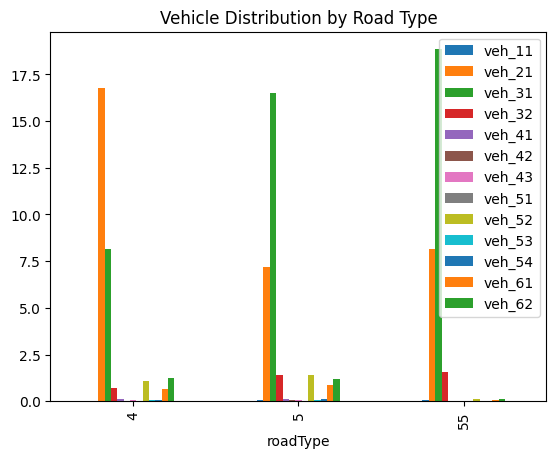

In [301]:
#Plot of Vehicle Distribution by Road Type
mix_df_filtered.plot(kind='bar', title = 'Vehicle Distribution by Road Type')

### HPMS Factor File

In [302]:
#Since HPMS Factors are County-Specific, delete duplicate values, 
hpms_df=hpms_df.replace(to_replace=r"\N",value=0)
hpms_df=hpms_df.drop_duplicates(subset=['County_FIPS'])

#Rename 'City_FIPS' column
hpms_df.rename(columns={'City_FIPS': 'CITY_FIPS'}, inplace=True)


In [303]:
#View HPMS Factor File
display(hpms_df)

,GeoID_WFRC,County_FIPS,CITY_FIPS,GeoID_text,HPMSF,HPMSR,HPMSL,HPMSA
0,1,57,0,WE,0.9553,0.9553,2.3454,0.9805
1,2,11,0,DA,0.9629,0.9629,2.4213,1.0782
2,3,35,0,SL,0.9624,0.9624,2.7055,1.0181
3,4,49,0,UT,1.0328,1.0328,2.7675,0.8969
4,55980,55980,55980,OG,0.8801,0.8801,3.5816,0.9931
7,1002,45,0,TO,1.1703,1.1703,3.6889,1.0460
8,1001,3,0,BE,0.8091,0.8091,1.7783,0.9957


<Axes: >

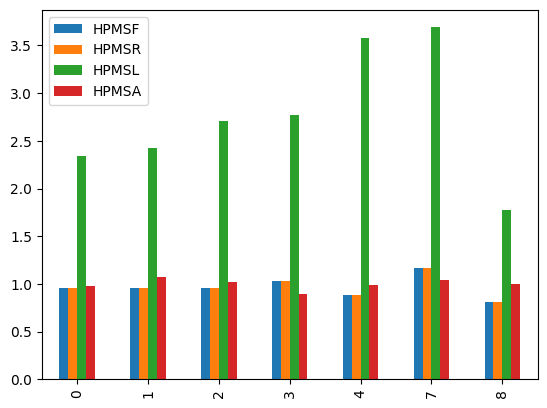

In [304]:
#View HPMS Chart
hpms_df[['HPMSF','HPMSR','HPMSL','HPMSA']].plot(kind='bar')

# Step 3: Process TDM Output

## Setup TDM DF for processing

In [305]:
#Initial setup
# Question: Filter TDM Data to county of interest (If desired)
#tdm = tdm_output[tdm_output['County_FIPS']== county_fips]
tdm = tdm_df.copy()

# Create "Link_ID" field
tdm["link_ID"] = tdm["A"].astype(str) + "_" + tdm["B"].astype(str)

# Create "year_ID" field
tdm["year_ID"] = year

#Set "road_type" field based on input "road.csv" file
tdm = tdm.merge(road_df, on='FT')

#The SQL script inserts ogden as a separate county here
tdm_ogden = tdm.where(tdm['CITY_FIPS']==55980)
tdm_ogden.dropna(inplace=True)
tdm_ogden['County_FIPS'] = 55980

#Add Ogden to end of TDM Dataframe
tdm = pd.concat([tdm, tdm_ogden], ignore_index=True)

#Reassign local roads to match Arterials
tdm['roadtype_ID2345'] = tdm['RoadType'].where(tdm['RoadType'] != 55, other=5)
if 'COUNTY_FIP' in tdm.columns: tdm.rename(columns={"COUNTY_FIP":"County_FIPS"}, inplace=True)


In [306]:
#Merge HPMS Factors onto TDM
tdm = pd.merge(tdm,hpms_df,on='County_FIPS')
                                                                          

In [307]:
# Create the HPMS dictionary
HPMS_type_dict = { 4: 'HPMSF', 5: 'HPMSA', 55: 'HPMSL'}

# Add a new column named 'HPMS_Factor_type' based on above dictionary
tdm['HPMS_factor_type'] = tdm['RoadType'].apply(lambda x: HPMS_type_dict.get(x))

# Define a function to apply to each row, selecting the right HPMS Factor column
def select_HPMS_column(row):
    column_to_select = row['HPMS_factor_type']
    return row[column_to_select]

tdm['HPMS_factor'] = tdm.apply(select_HPMS_column, axis=1)

tdm_hpms = tdm[['link_ID','RoadType','HPMSF','HPMSR','HPMSL','HPMSA', 'HPMS_factor']].copy()

## Calculate New Fields

In [308]:
#HPMS-Adjusted VMT
tdm['VMT_HPMS_W'] = tdm['VMT_JAN'] * tdm['HPMS_factor']
tdm['VMT_HPMS_S'] = tdm['VMT_JUL'] * tdm['HPMS_factor']

#VHT
tdm['VHT_FF_SPD'] = tdm['VMT_JAN'] / tdm['SFF']
tdm['VHT_AM'] = tdm['AM_VMT_W'] / tdm['AM_SPD']
tdm['VHT_MD'] = tdm['MD_VMT_W'] / tdm['MD_SPD']
tdm['VHT_PM'] = tdm['PM_VMT_W'] / tdm['PM_SPD']
tdm['VHT_EV'] = tdm['EV_VMT_W'] / tdm['EV_SPD']
#Question: Why do we define VHT only by the Winter VMT?
tdm['VHT'] = tdm['VHT_AM'] + tdm['VHT_MD'] + tdm['VHT_PM'] + tdm['VHT_EV']

#VHT Delay
tdm['VHT'] = tdm['VHT_AM'] + tdm['VHT_MD'] + tdm['VHT_PM'] + tdm['VHT_EV']
tdm['VHT_Delay_AM'] = np.where(tdm['SFF']>tdm['AM_SPD'], tdm['VHT_AM'] - (tdm['AM_VMT_W'] / tdm['SFF']) , 0)
tdm['VHT_Delay_MD'] = np.where(tdm['SFF']>tdm['MD_SPD'], tdm['VHT_MD'] - (tdm['MD_VMT_W'] / tdm['SFF']) , 0)
tdm['VHT_Delay_PM'] = np.where(tdm['SFF']>tdm['PM_SPD'], tdm['VHT_PM'] - (tdm['PM_VMT_W'] / tdm['SFF']) , 0)
tdm['VHT_Delay_EV'] = np.where(tdm['SFF']>tdm['EV_SPD'], tdm['VHT_EV'] - (tdm['EV_VMT_W'] / tdm['SFF']) , 0)
#Question: Do we need to do something to exclude centroid connectors from the lane miles calculation?
tdm['Lane_miles'] = tdm['LANES'] * tdm['DIST']
tdm['VHT_Delay'] = tdm['VHT_Delay_AM'] + tdm['VHT_Delay_MD'] + tdm['VHT_Delay_PM'] + tdm['VHT_Delay_EV']

#VC Checks
tdm['VMT_AM_VC>1.0'] = np.where(tdm['AM_VC'] > 1, tdm['AM_VMT_W'],0)
tdm['VMT_MD_VC>1.0'] = np.where(tdm['MD_VC'] > 1, tdm['MD_VMT_W'],0)
tdm['VMT_PM_VC>1.0'] = np.where(tdm['PM_VC'] > 1, tdm['PM_VMT_W'],0)
tdm['VMT_EV_VC>1.0'] = np.where(tdm['EV_VC'] > 1, tdm['EV_VMT_W'],0)

tdm['VMT_AM_VC>1.2'] = np.where(tdm['AM_VC'] > 1.2, tdm['AM_VMT_W'],0)
tdm['VMT_MD_VC>1.2'] = np.where(tdm['MD_VC'] > 1.2, tdm['MD_VMT_W'],0)
tdm['VMT_PM_VC>1.2'] = np.where(tdm['PM_VC'] > 1.2, tdm['PM_VMT_W'],0)
tdm['VMT_EV_VC>1.2'] = np.where(tdm['EV_VC'] > 1.2, tdm['EV_VMT_W'],0)

tdm['VMT_VC>1.0'] = tdm['VMT_AM_VC>1.0'] + tdm['VMT_MD_VC>1.0'] + tdm['VMT_PM_VC>1.0'] + tdm['VMT_EV_VC>1.0']
tdm['VMT_VC>1.2'] = tdm['VMT_AM_VC>1.2'] + tdm['VMT_MD_VC>1.2'] + tdm['VMT_PM_VC>1.2'] + tdm['VMT_EV_VC>1.2']

#Speed Bin Calculations
tdm['AM_SPD'] = tdm['AM_SPD'].where(tdm['RoadType'] != 55, other=12.9)
tdm['MD_SPD'] = tdm['MD_SPD'].where(tdm['RoadType'] != 55, other=12.9)
tdm['PM_SPD'] = tdm['PM_SPD'].where(tdm['RoadType'] != 55, other=12.9)
tdm['EV_SPD'] = tdm['EV_SPD'].where(tdm['RoadType'] != 55, other=12.9)

tdm['AM_SPD_bin'] = np.minimum(np.ceil((tdm['AM_SPD']+2.5)/5),16)
tdm['MD_SPD_bin'] = np.minimum(np.ceil((tdm['MD_SPD']+2.5)/5),16)
tdm['PM_SPD_bin'] = np.minimum(np.ceil((tdm['PM_SPD']+2.5)/5),16)
tdm['EV_SPD_bin'] = np.minimum(np.ceil((tdm['EV_SPD']+2.5)/5),16)

## Summarize VMT by Vehicle, County, Month, Road, Factor by HPMS and VMT Mix

In [309]:
# Create VMT Totals By County
vmt_county = tdm[['County_FIPS','VMT_JAN','VMT_JUL','VMT_HPMS_W','VMT_HPMS_S']].copy()
vmt_county = vmt_county.groupby(['County_FIPS']).sum().round()


In [310]:
#View VMT by County
display(vmt_county)

,VMT_JAN,VMT_JUL,VMT_HPMS_W,VMT_HPMS_S
County_FIPS,,,,
3,773528.0,956857.0,832377.0,1027147.0
11,6349007.0,7085325.0,7857965.0,8754538.0
35,24160438.0,26803848.0,28074712.0,31094680.0
49,15738939.0,17812287.0,17454205.0,19708725.0
57,4983119.0,5689955.0,5762180.0,6587373.0
55980,1546855.0,1698167.0,1987361.0,2181437.0


In [311]:
# Create VMT Totals By County and Road
vmt_county_road = tdm[['County_FIPS','year_ID','RoadType','roadtype_ID2345','VMT_JAN','VMT_JUL','VMT_HPMS_W','VMT_HPMS_S']].copy()
vmt_county_road = vmt_county_road.groupby(['County_FIPS','RoadType','roadtype_ID2345']).sum()
vmt_county_road.drop(columns=['year_ID'],inplace=True)

In [312]:
#View VMT Totals by County and Road
display(vmt_county_road)

VMT_JAN       VMT_JUL  \
County_FIPS RoadType roadtype_ID2345                               
3           4.0      4.0              1.038791e+03  1.564052e+03   
            5.0      5.0              6.927949e+05  8.598469e+05   
            55.0     5.0              7.969436e+04  9.544618e+04   
11          4.0      4.0              1.843295e+06  2.105679e+06   
            5.0      5.0              3.593644e+06  3.968608e+06   
            55.0     5.0              9.120679e+05  1.011038e+06   
35          4.0      4.0              6.989353e+06  7.928332e+06   
            5.0      5.0              1.487982e+07  1.635845e+07   
            55.0     5.0              2.291262e+06  2.517062e+06   
49          4.0      4.0              3.875257e+06  4.301275e+06   
            5.0      5.0              1.036079e+07  1.182795e+07   
            55.0     5.0              1.502888e+06  1.683065e+06   
57          4.0      4.0              2.103138e+05  2.468798e+05   
            5.0      5.0              4.126947e+06  4.699728e+06   
            55.0     5.0              6.458580e+05  7.433468e+05   
55980       4.0      4.0              2.034270e+03  2.319298e+03   
            5.0      5.0              1.370430e+06  1.504521e+06   
            55.0     5.0              1.743903e+05  1.913266e+05   

                                        VMT_HPMS_W    VMT_HPMS_S  
County_FIPS RoadType roadtype_ID2345                              
3           4.0      4.0              8.404860e+02  1.265475e+03  
            5.0      5.0              6.898159e+05  8.561495e+05  
            55.0     5.0              1.417205e+05  1.697319e+05  
11          4.0      4.0              1.774909e+06  2.027559e+06  
            5.0      5.0              3.874667e+06  4.278953e+06  
            55.0     5.0              2.208390e+06  2.448027e+06  
35          4.0      4.0              6.726553e+06  7.630227e+06  
            5.0      5.0              1.514915e+07  1.665454e+07  
            55.0     5.0              6.199011e+06  6.809911e+06  
49          4.0      4.0              4.002366e+06  4.442357e+06  
            5.0      5.0              9.292596e+06  1.060849e+07  
            55.0     5.0              4.159243e+06  4.657883e+06  
57          4.0      4.0              2.009128e+05  2.358443e+05  
            5.0      5.0              4.046472e+06  4.608083e+06  
            55.0     5.0              1.514795e+06  1.743446e+06  
55980       4.0      4.0              1.790361e+03  2.041214e+03  
            5.0      5.0              1.360974e+06  1.494140e+06  
            55.0     5.0              6.245963e+05  6.852555e+05

<Axes: xlabel='County_FIPS,RoadType,roadtype_ID2345'>

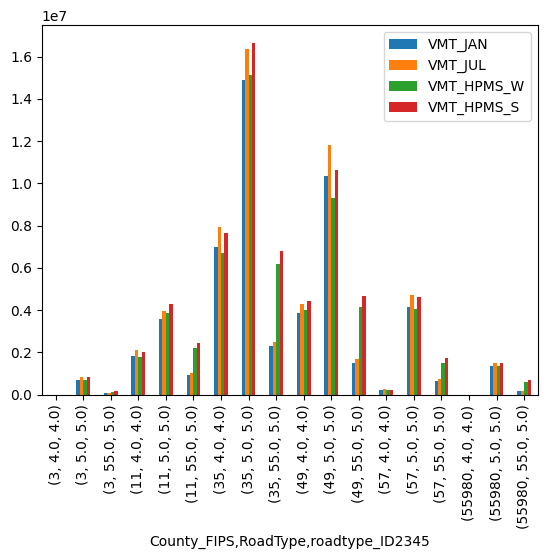

In [313]:
#View VMT by County and Road
vmt_county_road.plot(kind='bar')

In [314]:
# Merge Vehicle Mix Data
## Filter Vehicle Mix Data to modeled year
mix_filtered = mix_df[mix_df['Year'] == year]

##Group mix dataframe by county and roadtype
mix_filtered.rename(columns={'roadType':'RoadType'}, inplace=True)
mix_filtered.drop(columns=['Year'], inplace=True)
mix_filtered['County_FIPS'] = pd.to_numeric(mix_filtered['County_FIPS'])
mix_filtered['RoadType'] = pd.to_numeric(mix_filtered['RoadType'])
mix_grouped = mix_filtered.groupby(['County_FIPS','RoadType']).sum()

# Merge Mix Data to VMT Table

vmt_county_road_veh = pd.merge(vmt_county_road, mix_grouped, how='left', on=['County_FIPS','RoadType'])



def create_VMT_by_season(season):
    for i in range(len(mix_grouped.columns)):
        col_name = mix_grouped.columns[i]
        col_name = 'VMT_HPMS_' + season + col_name[col_name.find('_'):]
        vmt_county_road_veh[col_name] = vmt_county_road_veh['VMT_HPMS_'+season]*vmt_county_road_veh[mix_grouped.columns[i]].astype(float)

create_VMT_by_season('W')
create_VMT_by_season('S')

In [319]:
#Create VMT Totals by County and Vehicle

vmt_county_veh = vmt_county_road_veh.iloc[:,-26:]
vmt_county_veh.reset_index(inplace=True)
vmt_county_veh.drop(columns='RoadType', inplace=True)
vmt_county_veh = vmt_county_veh.apply(pd.to_numeric, errors='coerce')

vmt_county_veh = vmt_county_veh.groupby(['County_FIPS']).sum()

In [320]:
#View VMT Totals by County and Vehicle
display(vmt_county_veh)

,VMT_HPMS_W_11,VMT_HPMS_W_21,VMT_HPMS_W_31,VMT_HPMS_W_32,VMT_HPMS_W_41,VMT_HPMS_W_42,VMT_HPMS_W_43,VMT_HPMS_W_51,VMT_HPMS_W_52,VMT_HPMS_W_53,...,VMT_HPMS_S_32,VMT_HPMS_S_41,VMT_HPMS_S_42,VMT_HPMS_S_43,VMT_HPMS_S_51,VMT_HPMS_S_52,VMT_HPMS_S_53,VMT_HPMS_S_54,VMT_HPMS_S_61,VMT_HPMS_S_62
County_FIPS,,,,,,,,,,,,,,,,,,,,,
3,1952.128655,2.378409e+05,4.972840e+05,4.577092e+04,1456.001928,516.746863,731.450044,266.001205,16455.185354,1040.417099,...,5.646229e+04,1806.097813,640.985813,907.329654,329.934699,20411.757729,1290.571086,1495.059354,12642.634075,21913.693914
11,18369.080544,2.460273e+06,4.458693e+06,4.600403e+05,18116.764954,6790.620308,8326.847928,3112.288225,188056.760761,12331.826580,...,5.124584e+05,20228.986006,7582.529924,9297.630104,3474.956213,209980.482996,13769.489937,14595.507468,106800.922515,128555.813349
35,67472.193408,8.727486e+06,1.612264e+07,1.626205e+06,60863.617040,22212.405797,28294.264533,10200.179806,623623.185304,41243.508669,...,1.800993e+06,67501.942844,24635.142441,31379.920902,11312.130934,691643.062787,45742.422252,48883.035818,347828.310391,428964.211538
49,40749.075502,5.293020e+06,9.828136e+06,9.918961e+05,50949.583993,18870.016410,23877.043430,8682.989094,533686.978571,35089.212798,...,1.119786e+06,57678.402566,21361.432390,27029.867355,9829.630475,604170.105338,39723.468324,42330.845545,310007.883224,360012.507279
57,14454.022529,1.806023e+06,3.382904e+06,3.355180e+05,9391.385891,3365.974593,4403.059492,1533.385863,94888.219699,6326.623293,...,3.835681e+05,10735.458892,3847.744330,5033.253792,1752.865335,108468.582404,7232.086665,7728.851920,52752.848911,57684.507268
55980,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


<Axes: title={'center': 'Summer VMT by Vehicle Type'}, xlabel='County_FIPS'>

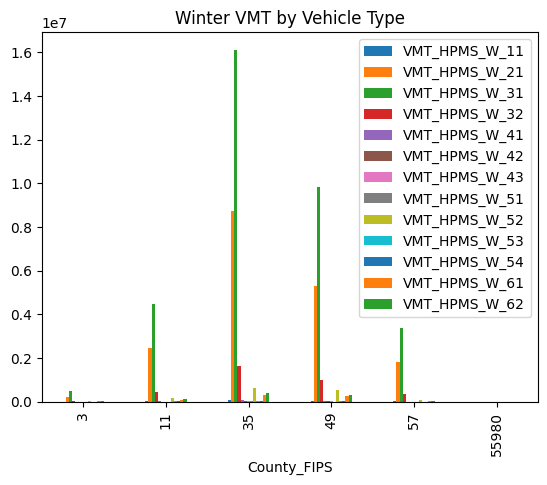

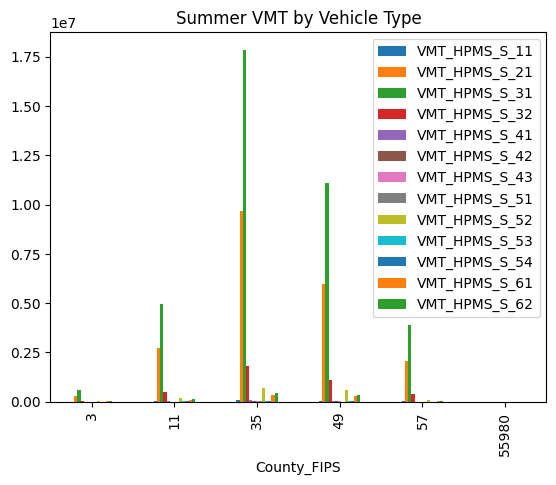

In [326]:
# View VMT by County and Vehicle
vmt_county_veh.iloc[:,:13:].plot(kind='bar', title = 'Winter VMT by Vehicle Type')
vmt_county_veh.iloc[:,13:].plot(kind='bar', title = 'Summer VMT by Vehicle Type')


# Step 4: Create MOVES Input Files

## 4a: Create "Road Type Distribution File"

In [327]:
# Create DataFrame for Moves lookup file for road distribution
column_names = ['COUNTY_FIPS','roadTypeID','sourceTypeID','Year_ID','VMT_Jan_veh','VMT_Jul_veh','VMT_Jan_veh_road', 'VMT_Jul_veh_road']

#Create List of Unique County FIPS Codes
unique_county_fips = tdm['County_FIPS'].unique()
unique_county_fips.sort()


#Create List of Unique Road Types
unique_roadtypeID = tdm['RoadType'].unique()
unique_roadtypeID.sort()


#Create List of Unique SourceTypes
mix_column_names = mix_df.columns
unique_sourcetypeID = []
for item in mix_column_names:
    if item.startswith('veh'):
        source_type = int(item.replace('veh_',''))
        unique_sourcetypeID.append(source_type)
unique_sourcetypeID.sort()

#Create Blank lists that will turn into columns for road distribution dataframe
county_column = []
roadTypeID_column = []
sourceTypeID_column = []
yearID_column = []
VMT_Jan_veh_column = []
VMT_Jul_veh_column = []
VMT_Jan_veh_road_column = []
VMT_Jul_veh_road_column = []

#For Loops to build the columns of the dataframe
for county in unique_county_fips:
    for road_type in unique_roadtypeID:
        for source_type in unique_sourcetypeID:
            county_column.append(county)
            roadTypeID_column.append(road_type)
            sourceTypeID_column.append(source_type)
            yearID_column.append(year)
            VMT_Jan_veh_column.append(vmt_county_veh.loc[county,'VMT_HPMS_W_' + str(source_type)])
            VMT_Jul_veh_column.append(vmt_county_veh.loc[county,'VMT_HPMS_S_' + str(source_type)])
            lookup_index = (county,road_type)
            VMT_Jan_veh_road_column.append(vmt_county_road_veh.loc[lookup_index,'VMT_HPMS_W_' + str(source_type)])
            VMT_Jul_veh_road_column.append(vmt_county_road_veh.loc[lookup_index,'VMT_HPMS_S_' + str(source_type)])
           
#List of columns
data_columns = [county_column,roadTypeID_column,sourceTypeID_column,yearID_column,VMT_Jan_veh_column,VMT_Jul_veh_column, VMT_Jan_veh_road_column, VMT_Jul_veh_road_column]

#Create Dictionary that pairs column name to data
road_dist_county_dict = {}
for i in range(len(column_names)):
    road_dist_county_dict[column_names[i]] = data_columns[i]

#Create Road Distribution dataframe
mv_road_dist_county = pd.DataFrame(road_dist_county_dict)

#Calculate VMT Fractions for each season
mv_road_dist_county['Jan_roadVMTFraction'] = mv_road_dist_county['VMT_Jan_veh_road'] / mv_road_dist_county['VMT_Jan_veh']
mv_road_dist_county['Jul_roadVMTFraction'] = mv_road_dist_county['VMT_Jul_veh_road'] / mv_road_dist_county['VMT_Jul_veh']

In [328]:
# View Road Type Distribution File
display(mv_road_dist_county)

,COUNTY_FIPS,roadTypeID,sourceTypeID,Year_ID,VMT_Jan_veh,VMT_Jul_veh,VMT_Jan_veh_road,VMT_Jul_veh_road,Jan_roadVMTFraction,Jul_roadVMTFraction
0,3,4.0,11,2050,1952.128655,2408.073778,1.706187,2.568914,0.000874,0.001067
1,3,4.0,21,2050,237840.856777,293396.869985,207.263846,312.066063,0.000871,0.001064
2,3,4.0,31,2050,497283.973391,613441.676534,433.346173,652.466105,0.000871,0.001064
3,3,4.0,32,2050,45770.918091,56462.286694,39.881060,60.046775,0.000871,0.001063
4,3,4.0,41,2050,1456.001928,1806.097813,4.656292,7.010730,0.003198,0.003882
...,...,...,...,...,...,...,...,...,...,...
229,55980,55.0,52,2050,0.000000,0.000000,NaN,NaN,NaN,NaN
230,55980,55.0,53,2050,0.000000,0.000000,NaN,NaN,NaN,NaN
231,55980,55.0,54,2050,0.000000,0.000000,NaN,NaN,NaN,NaN
232,55980,55.0,61,2050,0.000000,0.000000,NaN,NaN,NaN,NaN


## 4b: Create "VMT by Vehicle Type Distribution" File

In [332]:
# # Create MOVES lookup file for VMT by Vehicle

HPMSVtypeID_list = [10,25,40,50,60]
monthID = 7
dayID = 5
veh_type_column_names = ['County_FIPS','yearID','monthID','dayID','HPMSVtypeID','HPMS_VMT_W','HPMS_VMT_S']

#Create dictionary to map HPMS vehicle type to Mix Vehicle Type
HPMS_mix_dict = {
    10:[11],
    25:[21,31,32],
    40:[41,42,43],
    50:[51,52,53,54],
    60:[61,62]
}

#Create blank lists that will become the columns for the dataframe
veh_type_county_column = []
veh_type_year_column = []
veh_type_monthID_column = []
veh_type_dayID_column = []
veh_type_HPMSVtypeID_column = []
veh_type_HPMS_VMT_W = []
veh_type_HPMS_VMT_S = []

#Build out data in the column lists
for county in unique_county_fips:
    for vtype in HPMSVtypeID_list:
        veh_type_county_column.append(county)
        veh_type_year_column.append(year)
        veh_type_monthID_column.append(monthID)
        veh_type_dayID_column.append(dayID)
        veh_type_HPMSVtypeID_column.append(vtype)
        vmt_w = 0
        vmt_s = 0
        for source_type in HPMS_mix_dict[vtype]:
            vmt_w += vmt_county_veh.loc[county,'VMT_HPMS_W_'+str(source_type)]
            vmt_s += vmt_county_veh.loc[county,'VMT_HPMS_S_'+str(source_type)]
        veh_type_HPMS_VMT_W.append(vmt_w)
        veh_type_HPMS_VMT_S.append(vmt_s)

#Dictionary to map data columns to data names
veh_type_data_columns = [veh_type_county_column,veh_type_year_column,veh_type_monthID_column,veh_type_dayID_column,veh_type_HPMSVtypeID_column,veh_type_HPMS_VMT_W,veh_type_HPMS_VMT_S]
veh_type_dict = {}
for i in range(len(veh_type_column_names)):
    veh_type_dict[veh_type_column_names[i]] = veh_type_data_columns[i]

#Create VMT by Vehicle Type Distribution dataframe
mv_vmtbyveh_dist_county = pd.DataFrame(veh_type_dict)
mv_vmtbyveh_dist_county['HPMS_VMT_W'] = mv_vmtbyveh_dist_county['HPMS_VMT_W'].round(0)
mv_vmtbyveh_dist_county['HPMS_VMT_S'] = mv_vmtbyveh_dist_county['HPMS_VMT_S'].round(0)

In [331]:
# View VMT by Vehicle Type Distribution File
display(mv_vmtbyveh_dist_county)

,County_FIPS,yearID,monthID,dayID,HPMSVtypeID,HPMS_VMT_W,HPMS_VMT_S
0,3,2050,7,5,10,1952.0,2408.0
1,3,2050,7,5,25,780896.0,963301.0
2,3,2050,7,5,40,2704.0,3354.0
3,3,2050,7,5,50,18967.0,23527.0
4,3,2050,7,5,60,27858.0,34556.0
5,11,2050,7,5,10,18369.0,20462.0
6,11,2050,7,5,25,7379006.0,8219790.0
7,11,2050,7,5,40,33234.0,37109.0
8,11,2050,7,5,50,216573.0,241820.0
9,11,2050,7,5,60,210783.0,235357.0


## 4c: Create "Vehicle Population Distribution" file, (Using DAQ SourceTypeYear)

In [333]:
# Create Vehicle Population Distribution File

#Create blank lists that will become data columns
source_type_county_column = []
source_type_year_column = []
source_type_sourceTypeID = []
source_type_salesGrowthFactor = []
source_type_pop_column = []
source_type_migrationRate = []

#Create list of county FIPS that don't include ogden
counties_no_ogden = list(unique_county_fips[unique_county_fips != 55980])

#Populate column lists with data
for county in counties_no_ogden:
    for source_type in unique_sourcetypeID:
        row = source_type_pop_df.loc[(source_type_pop_df['yearID']==year) & (source_type_pop_df['countyid']==49000+county) & (source_type_pop_df['sourceTypeID']==source_type)]
        source_type_year_column.append(row['yearID'].values[0])
        source_type_county_column.append(county)
        source_type_sourceTypeID.append(row['sourceTypeID'].values[0])
        source_type_salesGrowthFactor.append(0)
        source_type_pop_column.append(row['pop'].values[0])
        source_type_migrationRate.append(0)

#Map Data Column names to Data
source_type_data_columns = [source_type_year_column,source_type_county_column,source_type_sourceTypeID,source_type_salesGrowthFactor,source_type_pop_column,source_type_migrationRate]
source_type_data_column_names = ['yearID','countyid','sourceTypeID','salesGrowthFactor','pop','migrationRate']
source_type_dict = {}

for i in range(len(source_type_data_columns)):
    source_type_dict[source_type_data_column_names[i]] = source_type_data_columns[i]

#Create Vehicle Population Distribution dataframe
mv_vehpop_dist_county = pd.DataFrame(source_type_dict)

In [334]:
# View Vehicle Population Distribution File
display(mv_vehpop_dist_county)

,yearID,countyid,sourceTypeID,salesGrowthFactor,pop,migrationRate
0,2050,3,11,0,2411.040,0
1,2050,3,21,0,11068.000,0
2,2050,3,31,0,55367.200,0
3,2050,3,32,0,5623.230,0
4,2050,3,41,0,157.358,0
...,...,...,...,...,...,...
60,2050,57,52,0,13257.300,0
61,2050,57,53,0,2217.080,0
62,2050,57,54,0,2155.180,0
63,2050,57,61,0,1612.710,0


## 4d: Create "Speed Distribution" File